In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
tabelle_keywords = pd.read_csv('../data/keywords.csv', dtype = {'id': int, 'keywords' : str}) #shape = (46419, 2)
tabelle_keywords_nonempty = tabelle_keywords[tabelle_keywords['keywords'] != '[]'] 

AttributeError: module 'numpy' has no attribute 'void'

In [ ]:
def mehrfacheintraege(df, column):
    counter_keywords = Counter(df[column])
    multiple_occurrences = [item for item, count in counter_keywords.items() if count > 1]
    if len(multiple_occurrences) == 0:
        print('Es gibt keine Mehrfacheinträge.')
        return 
    print('Es gibt ',len(multiple_occurrences),' Mehrfacheinträge.')
    return multiple_occurrences

multiple_occurrences_keywords = mehrfacheintraege(tabelle_keywords_nonempty, 'id')

Es gibt  532  Mehrfacheinträge.


In [ ]:
def remove_mehrfacheintraege(dataframe, column1, column2, mehrfacheintraege):
    df = dataframe.copy()
    df['gleichheit_temp'] = df.groupby(column1)[column2].transform(lambda x:x.nunique() == 1)
    if not df['gleichheit_temp'].all():
        print('Error: Infos gehen verloren')
        return
    df.drop(columns = 'gleichheit_temp', axis = 1, inplace = True)
    eintraege_to_remove = []
    for dup in mehrfacheintraege:
        eintraege_to_remove.append(df[df[column1] == dup].index[0])
    return df.drop(eintraege_to_remove)

tabelle_keywords_clean = remove_mehrfacheintraege(tabelle_keywords_nonempty, 'id', 'keywords', multiple_occurrences_keywords)
mehrfacheintraege(tabelle_keywords_clean, 'id')

Es gibt keine Mehrfacheinträge.


In [ ]:
tabelle_titles = pd.read_csv('../data/movies_metadata.csv', usecols=['id','original_title', 'genres'], dtype = {'id': int, 'original_title': str}, skiprows = [19731,29504,35588])

In [ ]:
multiple_occurences_titles = mehrfacheintraege(tabelle_titles, 'id')
tabelle_titles_temp = remove_mehrfacheintraege(tabelle_titles, 'id','original_title', multiple_occurences_titles)
multiple_occurences_titles = mehrfacheintraege(tabelle_titles_temp, 'id')
tabelle_titles_clean = remove_mehrfacheintraege(tabelle_titles, 'id','original_title', multiple_occurences_titles)
mehrfacheintraege(tabelle_keywords_clean, 'id')

Es gibt  29  Mehrfacheinträge.
Es gibt  1  Mehrfacheinträge.
Es gibt keine Mehrfacheinträge.


In [ ]:
tabelle = pd.merge(tabelle_keywords_clean, tabelle_titles_clean, how = 'left', on='id')

In [ ]:
def eintragtokeywords(string):
    keywords = string.rsplit(sep = '\'name\': ')
    keywords = keywords[1:]
    for i in range(len(keywords)):
        n=0
        while(keywords[i][n] != '}'):
            n +=1
        keywords[i] = keywords[i][1:n-1]
    return keywords

tabelle['keywords'] = tabelle['keywords'].transform(lambda x: eintragtokeywords(x))
tabelle['|keywords|'] = tabelle['keywords'].transform(lambda x: len(x))
tabelle['genres'] = tabelle['genres'].transform(lambda x : eintragtokeywords(x))

print('Unsere Tablle enthält', len(tabelle), 'Filme, die mit', len(tabelle.explode('keywords')['keywords'].unique()) ,'unterschiedlichen Schlagworten insgesamt',tabelle['|keywords|'].sum(),'mal verschlagwortet wurden.')

Unsere Tablle enthält 31110 Filme, die mit 19956 unterschiedlichen Schlagworten insgesamt 156725 mal verschlagwortet wurden.


<function matplotlib.pyplot.show(close=None, block=None)>

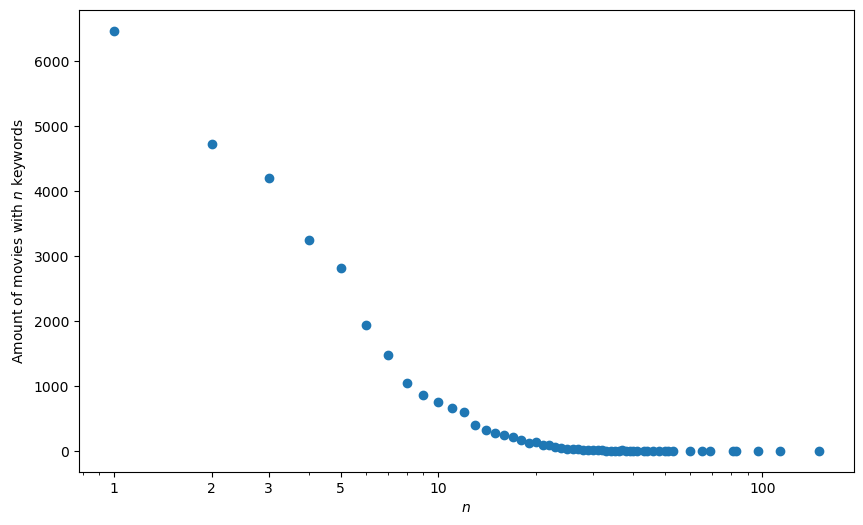

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(tabelle['|keywords|'].value_counts().keys(), tabelle['|keywords|'].value_counts())
plt.ylabel('Amount of movies with $n$ keywords')
plt.xlabel('$n$')
plt.xscale('log')
plt.xticks([1,2,3,5,10,100],[1,2,3,5,10,100])
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/verteilung_|keywords|.png')
plt.show

In [ ]:
#löscht alle Schlagwörter, die nicht in filter_dict vorkommen aus dem Eintrag keywords
def filter(keywords, filter_dict): 
    keywords_filtered = []
    for keyword in keywords:
        if keyword in filter_dict.keys():
            keywords_filtered.append(keyword)
    return keywords_filtered

#löscht abwechselnd alle Schlägwörter die <= agreement mal vorkommen und alle Filme mit <3 Schlagwörtern,
#bis alle Filme mind. 3 Schlagwörter haben und jedes Schlagwort mind. 3 mal vorkommt.
def clean_data(df, agreement): 
    if '|keywords|' not in df.columns:
        print('das ist nur für das data df')
    data = df.copy()
    rein = True
    j = 0
    while rein:
        seps_dict = {}
        for i in data.index:
            for keyword in data.loc[i, 'keywords']:
                seps_dict[keyword] = seps_dict.get(keyword, [])
                seps_dict[keyword].append(data.loc[i, 'id'])
        seps_dict_clean = {}
        for a in seps_dict.keys():               
            if len(seps_dict[a]) >= agreement:
                seps_dict_clean[a] = seps_dict[a]
        
        rein = (len(seps_dict) != len(seps_dict_clean))    

        data['keywords_temp'] = data['keywords'].transform(lambda x : filter(x, seps_dict_clean))
        data['|keywords_temp|'] = data['keywords_temp'].transform(lambda x : len(x))
        data = data[data['|keywords_temp|'] >= 3]
        
        data['keywords'] = data['keywords_temp']
        data['|keywords|'] = data['|keywords_temp|']
        data.drop(columns = ['keywords_temp','|keywords_temp|'], inplace = True)
        j+=1
    data = data.reset_index(drop=True)
    print('j = ',j-1)
    return data

In [ ]:
data = clean_data(tabelle, 3)
data.to_csv('../data/data_F3.csv')

j =  3


In [ ]:
data_F10 = clean_data(tabelle, 10)
data_F10.to_csv('../data/data_F10.csv')

j =  5


In [ ]:
data_F24 = clean_data(tabelle, 24)
data_F24.to_csv('../data/data_F24.csv')

j =  5


<function matplotlib.pyplot.show(close=None, block=None)>

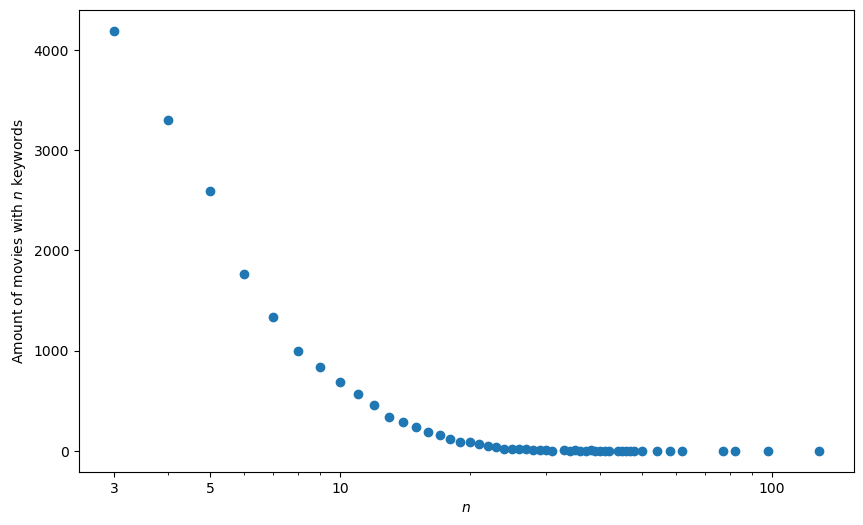

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(data['|keywords|'].value_counts().keys(), data['|keywords|'].value_counts())
plt.ylabel('Amount of movies with $n$ keywords')
plt.xlabel('$n$')
plt.xscale('log')
plt.xticks([3,5,10,100],[3,5,10,100])
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/verteilung_|keywords|_M.png')
plt.show

#TODO löschen?!

<function matplotlib.pyplot.show(close=None, block=None)>

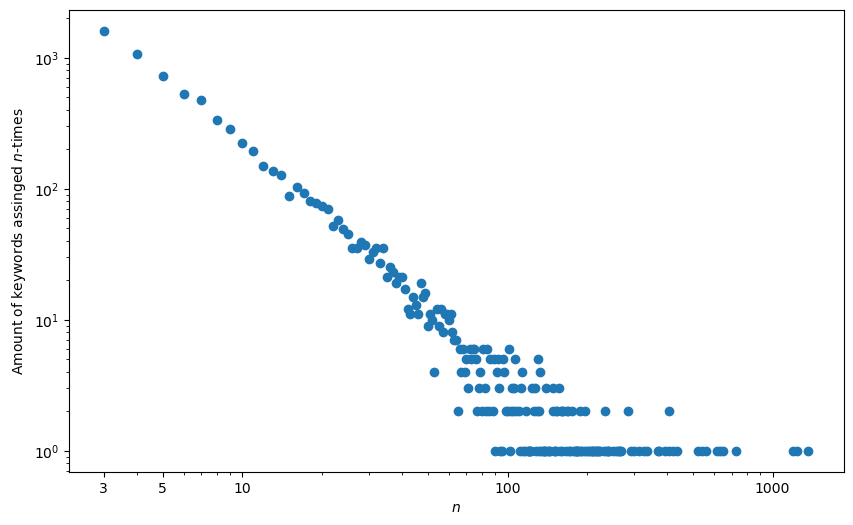

In [ ]:
seps_dict = {}
for i in data.index:
    for keyword in data.loc[i, 'keywords']:
        seps_dict[keyword] = seps_dict.get(keyword, [])
        seps_dict[keyword].append(data.loc[i, 'id'])        
verteilung_seps = {a : len(seps_dict[a]) for a in seps_dict.keys()}
verteilung_counter = Counter(verteilung_seps.values())
x_values = sorted(verteilung_counter.keys())
y_values = [verteilung_counter[a] for a in x_values]
plt.figure(figsize = (10,6))
plt.scatter(x_values,y_values, marker = 'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.xticks([3,5,10,100,1000], [3,5,10,100,1000])
plt.ylabel('Amount of keywords assinged $n$-times')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/verteilung_vec_k.png')
plt.show

In [ ]:
print('F3 enthält', len(data), 'Filme, die mit', len(data.explode('keywords')['keywords'].unique()) ,'unterschiedlichen Schlagworten insgesamt',data['|keywords|'].sum(),'mal verschlagwortet wurden.')

Data enthält 18513 Filme, die mit 7622 unterschiedlichen Schlagworten insgesamt 123466 mal verschlagwortet wurden.


In [ ]:
print('F10 enthält', len(data_F10), 'Filme, die mit', len(data_F10.explode('keywords')['keywords'].unique()) ,'unterschiedlichen Schlagworten insgesamt',data_F10['|keywords|'].sum(),'mal verschlagwortet wurden.')

Data K10 enthält 15567 Filme, die mit 2484 unterschiedlichen Schlagworten insgesamt 92717 mal verschlagwortet wurden.


In [ ]:
print('F24 enthält', len(data_F24), 'Filme, die mit', len(data_F24.explode('keywords')['keywords'].unique()) ,'unterschiedlichen Schlagworten insgesamt',data_F24['|keywords|'].sum(),'mal verschlagwortet wurden.')